In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import optuna
from optuna.visualization import plot_param_importances
import sklearn
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import itertools
import shap

In [492]:
def plot_confusion_matrix(cm, classes, title):
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.grid(False)

### Loading in the data with the desired features

In [3]:
cols = ['gender', 'birthyr', 'educ', 'race', 'countyfips', 'pew_religimp', 'newsint', 'CC16_351I', 'CC16_302', 'CC16_331_7', 'CC16_330d', 'CC16_332a', 'CC16_351K', 'CC16_335', 'CC16_364c']
df = pd.read_csv('data/CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t', header=0, usecols=cols)[cols]
df = df[(df.CC16_364c == 1.0) | (df.CC16_364c == 2.0) | (df.CC16_364c == 7.0)] # getting only the people who preferred Trump, Clinton, or weren't sure

In [178]:
df

,gender,birthyr,educ,race,countyfips,pew_religimp,newsint,CC16_351I,CC16_302,CC16_331_7,CC16_330d,CC16_332a,CC16_351K,CC16_335,CC16_364c
0,2,1969,2,1,33011.0,2.0,2.0,1.0,3.0,1,2.0,1.0,1.0,1.0,1.0
2,2,1964,2,2,29155.0,1.0,2.0,1.0,5.0,2,1.0,2.0,1.0,1.0,2.0
3,2,1988,2,2,1047.0,2.0,2.0,1.0,4.0,2,1.0,2.0,1.0,1.0,7.0
4,2,1982,5,1,8069.0,4.0,1.0,2.0,2.0,2,1.0,2.0,1.0,1.0,2.0
5,2,1963,2,6,1089.0,1.0,3.0,1.0,4.0,1,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64594,1,1967,2,1,32003.0,2.0,1.0,1.0,2.0,1,1.0,1.0,1.0,1.0,1.0
64595,1,1990,3,2,36047.0,1.0,1.0,2.0,1.0,2,1.0,1.0,1.0,1.0,1.0
64597,1,1978,2,1,22051.0,2.0,1.0,2.0,2.0,2,2.0,1.0,1.0,1.0,2.0
64598,1,1987,2,1,44007.0,4.0,1.0,2.0,2.0,2,1.0,1.0,1.0,1.0,2.0


### Verifying that there are no "skipped" responses, crosschecked to the data source

In [170]:
def find_answers(feat):
    return df[feat].unique()
feats = df.columns.tolist()
feats.remove('birthyr')
for feat in feats:
    print(f'{feat} : {find_answers(feat)}')

countyfips : [33011. 29155.  1047. ... 48407. 48501. 28143.]
gender : [2 1]
educ : [2 5 3 4 6 1]
race : [1 2 6 4 3 5 7 8]
CC16_302 : [3. 5. 4. 2. 6. 1.]
CC16_330d : [2. 1.]
CC16_331_7 : [1 2]
CC16_332a : [1. 2.]
CC16_335 : [1. 2.]
CC16_351I : [1. 2.]
CC16_351K : [1. 2.]
CC16_364c : [1. 2. 7.]
pew_religimp : [2. 1. 4. 3.]
newsint : [2. 1. 3. 7. 4.]


### Data Cleaning

In [4]:
df.dropna(inplace=True)
df = df.astype(int)

In [5]:
df.rename(columns={'birthyr': 'age', 'countyfips': 'state'}, inplace=True)
df.age = 2016 - df.age
df['state'] = df['state'].map(lambda x: f'{x:05}'[:2])

In [182]:
df

,gender,age,educ,race,state,pew_religimp,newsint,CC16_351I,CC16_302,CC16_331_7,CC16_330d,CC16_332a,CC16_351K,CC16_335,CC16_364c
0,2,47,2,1,33,2,2,1,3,1,2,1,1,1,1
2,2,52,2,2,29,1,2,1,5,2,1,2,1,1,2
3,2,28,2,2,01,2,2,1,4,2,1,2,1,1,7
4,2,34,5,1,08,4,1,2,2,2,1,2,1,1,2
5,2,53,2,6,01,1,3,1,4,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64594,1,49,2,1,32,2,1,1,2,1,1,1,1,1,1
64595,1,26,3,2,36,1,1,2,1,2,1,1,1,1,1
64597,1,38,2,1,22,2,1,2,2,2,2,1,1,1,2
64598,1,29,2,1,44,4,1,2,2,2,1,1,1,1,2


### Verifying that there are no highly correlated features

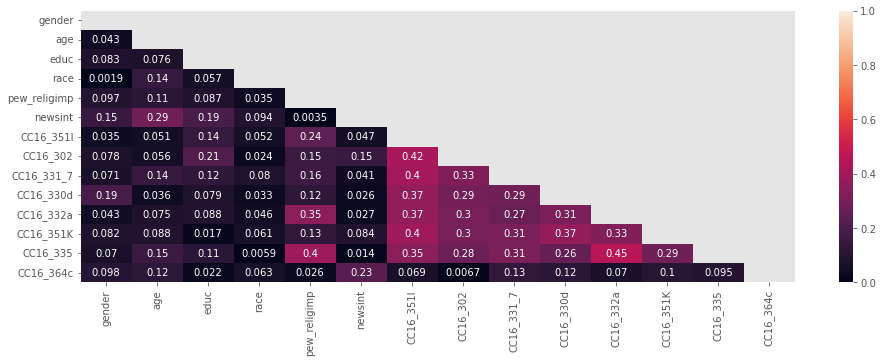

In [162]:
plt.figure(figsize=(16, 5))
corr = df.corr().abs()
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
corr = corr.where(cond=mask)
sns.heatmap(corr, annot=True, vmin=0, vmax=1);

### splitting the data

In [6]:
train, test = train_test_split(df, stratify=df.CC16_364c, test_size=0.2, random_state=42)
data_train, data_eval, label_train, label_eval = train_test_split(train.drop('CC16_364c', axis=1), train.CC16_364c, stratify=train.CC16_364c, test_size=0.3, random_state=42)
data_test, label_test = test.drop('CC16_364c', axis=1), test.CC16_364c

In [7]:
data_train, data_test, label_train, label_test = train_test_split(df.drop('CC16_364c', axis=1), df.CC16_364c, stratify=df.CC16_364c, test_size=0.2, random_state=42)

In [218]:
df.CC16_364c.value_counts()

2    27025
1    18763
7     6366
Name: CC16_364c, dtype: int64

In [221]:
label_train.value_counts()

2    15134
1    10507
7     3565
Name: CC16_364c, dtype: int64

### making the model

In [8]:
categorical_features_indices = np.where(train.dtypes != int)[0]

In [9]:
classifier = CatBoostClassifier(iterations=300, depth=3, learning_rate=0.1, loss_function='MultiClassOneVsAll')
classifier.fit(data_train, label_train, cat_features=categorical_features_indices, eval_set=(data_eval, label_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6440417	test: 0.6439647	best: 0.6439647 (0)	total: 182ms	remaining: 54.3s
1:	learn: 0.6036748	test: 0.6038626	best: 0.6038626 (1)	total: 227ms	remaining: 33.8s
2:	learn: 0.5693314	test: 0.5697014	best: 0.5697014 (2)	total: 263ms	remaining: 26s
3:	learn: 0.5403087	test: 0.5409969	best: 0.5409969 (3)	total: 298ms	remaining: 22s
4:	learn: 0.5159915	test: 0.5165951	best: 0.5165951 (4)	total: 335ms	remaining: 19.8s
5:	learn: 0.4948987	test: 0.4958567	best: 0.4958567 (5)	total: 373ms	remaining: 18.3s
6:	learn: 0.4765191	test: 0.4773502	best: 0.4773502 (6)	total: 413ms	remaining: 17.3s
7:	learn: 0.4607714	test: 0.4617018	best: 0.4617018 (7)	total: 453ms	remaining: 16.5s
8:	learn: 0.4468981	test: 0.4480260	best: 0.4480260 (8)	total: 493ms	remaining: 15.9s
9:	learn: 0.4348542	test: 0.4358163	best: 0.4358163 (9)	total: 529ms	remaining: 15.3s
10:	learn: 0.4240138	test: 0.4248861	best: 0.4248861 (10)	total: 561ms	remaining: 14.7s
11:	learn: 0.4141223	test: 0.4148780	best: 0.4148780 (11

In [524]:
preds = classifier.predict(data_test)

In [279]:
print('F1 score: ', f1_score(label_test, preds, average='weighted'))

F1 score:  0.7595449972641367


### classifier cm

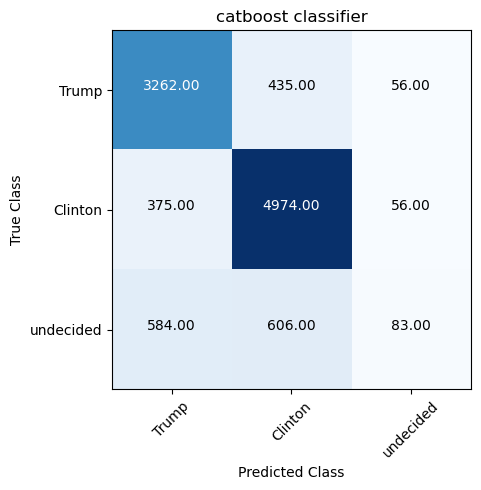

In [496]:
cm = confusion_matrix(label_test, preds, labels=[1, 2, 7])
plot_confusion_matrix(cm, ['Trump', 'Clinton', 'undecided'], 'catboost classifier')

In [10]:
alternate = df.copy()
alternate.replace({"CC16_364c": {1: 0, 7: 1}}, inplace=True)
atrain, atest = train_test_split(alternate, stratify=alternate.CC16_364c, test_size=0.2, random_state=42)
adata_train, adata_eval, alabel_train, alabel_eval = train_test_split(atrain.drop('CC16_364c', axis=1), atrain.CC16_364c, stratify=atrain.CC16_364c, test_size=0.3, random_state=42)
adata_test, alabel_test = atest.drop('CC16_364c', axis=1), atest.CC16_364c

In [11]:
regressor = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='MultiRMSE')
regressor.fit(adata_train, alabel_train, cat_features=categorical_features_indices, eval_set=(adata_eval, alabel_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8769636	test: 0.8761293	best: 0.8761293 (0)	total: 13ms	remaining: 13s
1:	learn: 0.8367977	test: 0.8354114	best: 0.8354114 (1)	total: 28.6ms	remaining: 14.3s
2:	learn: 0.8017520	test: 0.7996390	best: 0.7996390 (2)	total: 45.1ms	remaining: 15s
3:	learn: 0.7715383	test: 0.7681920	best: 0.7681920 (3)	total: 61.4ms	remaining: 15.3s
4:	learn: 0.7453542	test: 0.7413866	best: 0.7413866 (4)	total: 76.3ms	remaining: 15.2s
5:	learn: 0.7224691	test: 0.7178858	best: 0.7178858 (5)	total: 91.7ms	remaining: 15.2s
6:	learn: 0.7030736	test: 0.6980026	best: 0.6980026 (6)	total: 108ms	remaining: 15.3s
7:	learn: 0.6848884	test: 0.6797270	best: 0.6797270 (7)	total: 126ms	remaining: 15.6s
8:	learn: 0.6699085	test: 0.6639027	best: 0.6639027 (8)	total: 144ms	remaining: 15.8s
9:	learn: 0.6571541	test: 0.6504903	best: 0.6504903 (9)	total: 162ms	remaining: 16.1s
10:	learn: 0.6457012	test: 0.6387317	best: 0.6387317 (10)	total: 181ms	remaining: 16.2s
11:	learn: 0.6353713	test: 0.6280479	best: 0.6280479

In [451]:
preds = regressor.predict(adata_test)

In [452]:
preds.max()

2.5308100474041995

In [453]:
preds.min()

-0.19175242367319867

In [310]:
label_test.value_counts()

2    5405
1    3753
7    1273
Name: CC16_364c, dtype: int64

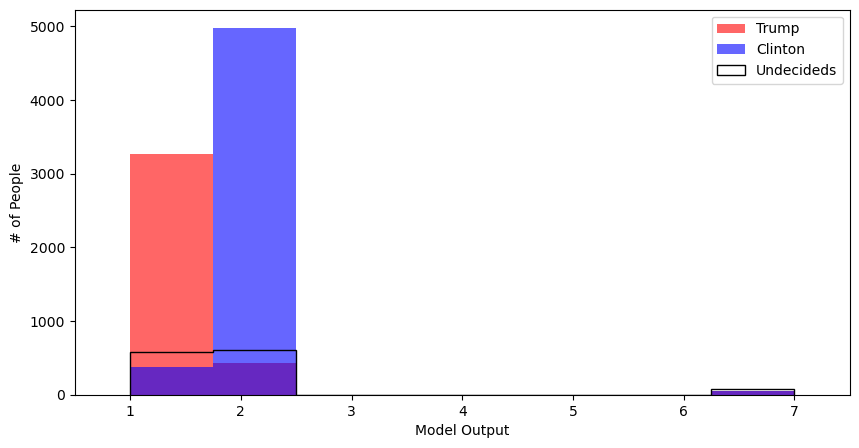

In [387]:
plot_classifier_predictions(classifier, data_test, label_test)

In [529]:
np.unique(preds[label_test == 1], return_counts=True)

(array([1, 2, 7], dtype=int64), array([3262,  435,   56], dtype=int64))

In [530]:
np.unique(preds[label_test == 2], return_counts=True)

(array([1, 2, 7], dtype=int64), array([ 375, 4974,   56], dtype=int64))

In [531]:
np.unique(preds[label_test == 7], return_counts=True)

(array([1, 2, 7], dtype=int64), array([584, 606,  83], dtype=int64))

In [532]:
courses

['Trump', 'Undecided', 'Clinton']

In [533]:
values

[20, 15, 30]

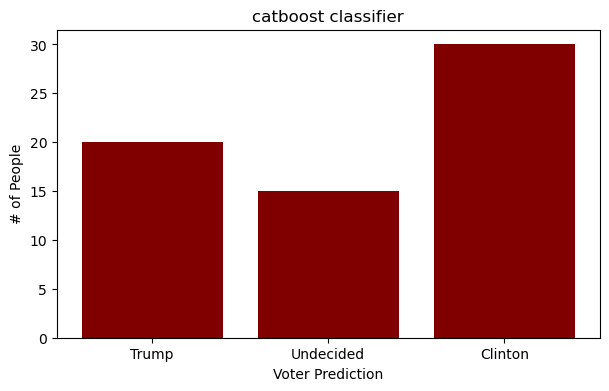

In [522]:
fig = plt.figure(figsize = (7, 4))
data = {'Trump':20, 'Undecided':15, 'Clinton':30,}
courses = list(data.keys())
values = list(data.values())

plt.bar(courses, values, color ='maroon', width = 0.8)
classes = ['Trump', 'Undecided', 'Clinton']
plt.bar(classes, values, color ='red', width = 0.8)

plt.xlabel("Voter Prediction")
plt.ylabel("# of People")
plt.title("catboost classifier")
plt.show()
# plt.figure(figsize=(10,5))
# y_pred = model.predict(data_test)
# plt.hist(y_pred[label_test == 1], bins=8, alpha=0.6, label='Trump', color='red')
# plt.hist(y_pred[label_test == 2], bins=8, alpha=0.6, label='Clinton', color='blue')
# plt.hist(y_pred[label_test == 7], bins=8, label='Undecideds', color='black', histtype=u'step')
# plt.xlabel('Model Output')
# plt.ylabel('# of People')
# plt.xlim([0.5, 7.5])
# plt.legend()
# # plt.subplots_adjust(hspace=0.4)
# # plt.subplots_adjust(wspace=0.3)
# plt.show()

In [329]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [484]:
def maximize_f1(model, data_test, label_test):
    preds = model.predict(data_test)
    deltas = np.linspace(0, 0.2, num=100)
    delta_f1_dict = {}
    for delta in deltas:
        greater = np.where(preds > 1 + delta, 2, preds)
        less_and_greater = np.where(greater < 1 - delta, 0, greater)
        final = np.where((1 - delta <= less_and_greater) & (less_and_greater <= 1 + delta), 1, less_and_greater)
        delta_f1_dict[delta] = f1_score(alabel_test, final, average='weighted')
    d = max(delta_f1_dict, key=delta_f1_dict.get)
    print(f'delta of {np.round(d, 2)} results in best f1 score of {np.round(delta_f1_dict[d], 3)}')
    print(f'Model Output < {1-delta} gets predicted as a Trump Voter')
    print(f'Model Output > {1+delta} gets predicted as a Clinton Voter')
    print(f'{1-delta} <= Model Output <= {1+delta} gets predicted as an Undecided Voter')
    greater = np.where(preds > 1 + d, 2, preds)
    less_and_greater = np.where(greater < 1 - d, 0, greater)
    return np.where((1 - d <= less_and_greater) & (less_and_greater <= 1 + d), 1, less_and_greater)

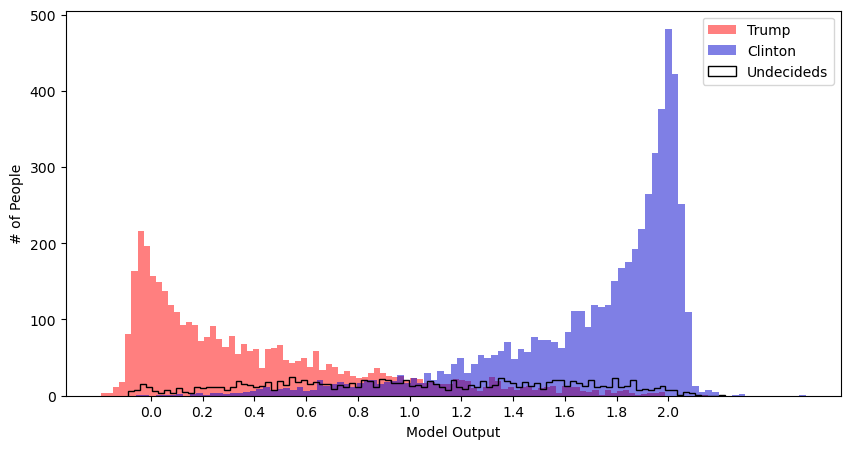

In [457]:
plot_regressor_predictions(regressor, adata_test, alabel_test)

In [485]:
final = maximize_f1(regressor, adata_test, alabel_test)

delta of 0.18 results in best f1 score of 0.775
Model Output < 0.8 gets predicted as a Trump Voter
Model Output > 1.2 gets predicted as a Clinton Voter
0.8 <= Model Output <= 1.2 gets predicted as an Undecided Voter


### manual threshold with regressor cm

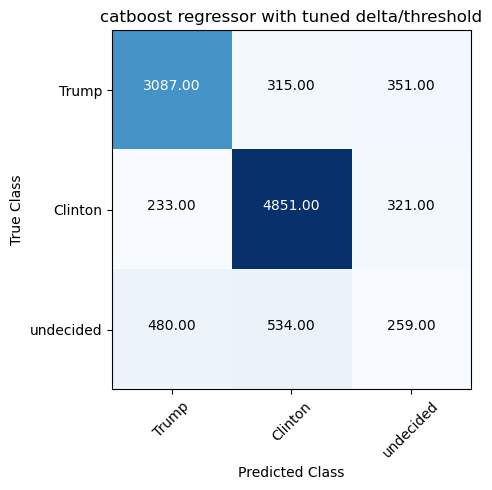

In [493]:
cm = confusion_matrix(alabel_test, final, labels=[0, 2, 1])
plot_confusion_matrix(cm, ['Trump', 'Clinton', 'undecided'], 'catboost regressor with tuned delta/threshold')

In [13]:
shap.initjs()

In [12]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(adata_train)

In [579]:
start=1

In [595]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [596]:
start=2

In [597]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [598]:
start=3

In [599]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [600]:
start=4

In [601]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [602]:
start=5

In [603]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [606]:
start=6

In [607]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [608]:
start=7

In [609]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [610]:
start=8

In [611]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [612]:
start=9

In [613]:
shap.force_plot(explainer.expected_value, shap_values[start,:], adata_train.iloc[start,:])

In [22]:
shap.force_plot(explainer.expected_value, shap_values[:1000], adata_train[:1000])

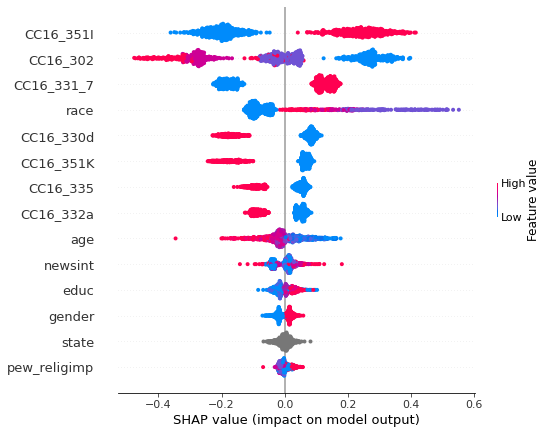

In [22]:
shap.summary_plot(shap_values[1000:2000], adata_train[1000:2000])

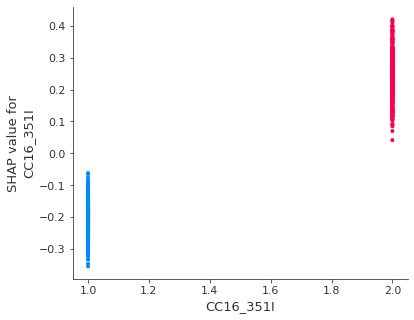

In [21]:
shap.dependence_plot('CC16_351I', shap_values[:1000], adata_train[:1000], interaction_index='CC16_351I')

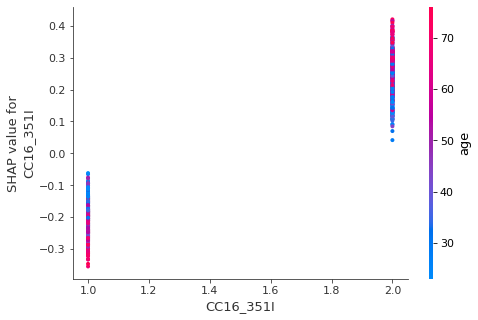

In [14]:
shap.dependence_plot('CC16_351I', shap_values[:1000], adata_train[:1000])

In [15]:
# pip install matplotlib==3.2.2 --user

In [1]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.2.2


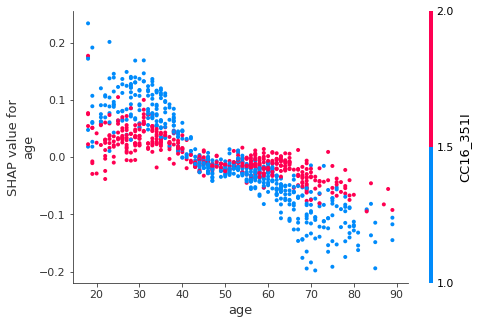

In [20]:
shap.dependence_plot('age', shap_values[:1000], adata_train[:1000])

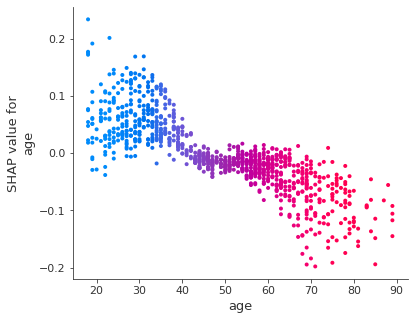

In [19]:
shap.dependence_plot('age', shap_values[:1000], adata_train[:1000], interaction_index='age')

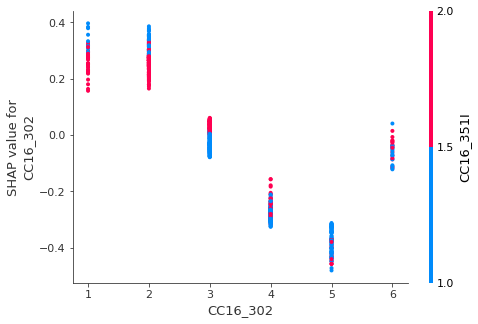

In [24]:
shap.dependence_plot("CC16_302", shap_values[:1000], adata_train[:1000])

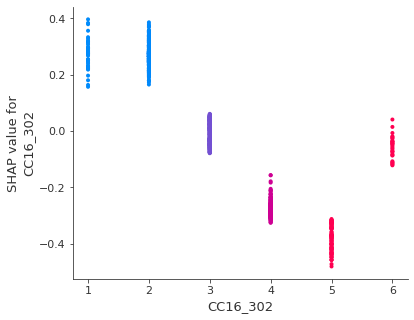

In [59]:
shap.dependence_plot("CC16_302", shap_values[:1000], adata_train[:1000], interaction_index='CC16_302')

In [604]:
def plot_regressor_predictions(model, data_test, label_test):
    plt.figure(figsize=(10,5))
    y_pred = model.predict(data_test)
    plt.hist(y_pred[label_test == 0], bins=100, alpha=0.5, label='Trump', color='red')
    plt.hist(y_pred[label_test == 2], bins=100, alpha=0.5, label='Clinton', color='mediumblue')
    plt.hist(y_pred[label_test == 1], bins=100, label='Undecideds', color='black', histtype=u'step')
    plt.xlabel('Model Output')
    plt.ylabel('# of People')
    plt.legend()
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [605]:
def plot_classifier_predictions(model, data_test, label_test):
    plt.figure(figsize=(10,5))
    y_pred = model.predict(data_test)
    plt.hist(y_pred[label_test == 1], bins=8, alpha=0.6, label='Trump', color='red')
    plt.hist(y_pred[label_test == 2], bins=8, alpha=0.6, label='Clinton', color='blue')
    plt.hist(y_pred[label_test == 7], bins=8, label='Undecideds', color='black', histtype=u'step')
    plt.xlabel('Model Output')
    plt.ylabel('# of People')
    plt.xlim([0.5, 7.5])
    plt.legend()
    plt.subplots_adjust(hspace=0.4)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [287]:
preds

array([ 0.01671659,  1.00710851,  1.01664128, ...,  0.50524968,
       -0.00106029,  0.88646682])

### misc

In [189]:
states = pd.read_csv('data/states.csv', header=0, dtype={'state_fips': str})

In [192]:
df.dtypes

gender           int32
age              int32
educ             int32
race             int32
state           object
pew_religimp     int32
newsint          int32
CC16_351I        int32
CC16_302         int32
CC16_331_7       int32
CC16_330d        int32
CC16_332a        int32
CC16_351K        int32
CC16_335         int32
CC16_364c        int32
dtype: object

gender 1-male, 2-female

educ

1971 1 No HS
16381 2 High school graduate
15685 3 Some college
7169 4 2-year
14884 5 4-year
8510 6 Post-grad

race 

46289 1 White
7926 2 Black
5238 3 Hispanic
2278 4 Asian
522 5 Native American
135 8 Middle Eastern
1452 6 Mixed
760 7 Other

marstat

34495 1 Married
1021 2 Separated
6715 3 Divorced
2928 4 Widowed
16550 5 Single
2835 6 Domestic partnership

CC16 330d (ban assault rifles)

42603 1 Support
21548 2 Oppose